### Import Library

In [10]:
from __future__ import division
import cv2 
import numpy as np
import glob
import csv
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

### Feature Extraction

Menggunakan Ekstraksi fitur HSV. Step yang digunakan adalah:
1. Masking Dataset
2. Gunakan Ekstraksi fitur HSV, lalu simpan ke dalam bentuk CSV

#### Masking

In [11]:
# Path folder utama yang berisi subfolder untuk setiap kelas
folder_utama = 'dataset_rambutan'

# Membaca semua subfolder di dalam folder utama
kelas_folders = glob.glob(os.path.join(folder_utama, '*'))

for kelas_folder in kelas_folders:
    # Membaca semua file gambar dalam subfolder kelas
    path = os.path.join(kelas_folder, '*.*')
    
    for bb, file in enumerate(glob.glob(path)):
        # Membuat kernel untuk nanti masking
        kernelOpen = np.ones((5, 5))
        kernelClose = np.ones((20, 20))

        # Baca gambar rgb
        rgb = cv2.imread(file)

        # Convert BGR to HSV
        hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)

        lower_white = np.array([0, 0, 168])
        upper_white = np.array([172, 111, 255])

        whitemask = cv2.inRange(hsv, lower_white, upper_white)

        # Invers mask putih agar yang terdeteksi adalah yang bukan putih
        non_whitemask = cv2.bitwise_not(whitemask)

        # Add a range for grey colors (adjust the values based on your needs)
        lower_grey = np.array([0, 0, 100])
        upper_grey = np.array([172, 30, 255])

        # Create a mask for grey colors
        greymask = cv2.inRange(hsv, lower_grey, upper_grey)

        # Combine masks to exclude white and grey regions
        non_whitemask_no_grey = cv2.bitwise_and(non_whitemask, cv2.bitwise_not(greymask))

        # Gunakan operasi open dengan kernel yang tadi di atas
        maskOpen = cv2.morphologyEx(non_whitemask_no_grey, cv2.MORPH_OPEN, kernelOpen)

        # Hasil dari open dipakai di close ini
        maskClose = cv2.morphologyEx(maskOpen, cv2.MORPH_CLOSE, kernelClose)

        # Hasil akhirnya masking dari close
        maskFinal = maskClose

        # Setelah itu gunakan bitwise untuk menyatukan gambarnya, hanya menggunakan hsv bukan rgbnya
        maskFinally = cv2.bitwise_and(hsv, hsv, mask=maskFinal)

        # Resize gambar ke 256x256
        resized_image = cv2.resize(maskFinally, (256, 256), interpolation=cv2.INTER_AREA)

        # Simpan gambar hasil masking dan resizing sesuai dengan struktur folder
        output_folder = os.path.join('masking_resized', os.path.basename(kelas_folder))
        os.makedirs(output_folder, exist_ok=True)
        
        # Gunakan label kelas sebagai nama file
        class_label = os.path.basename(kelas_folder)
        output_filename = f'masking_{class_label}_{bb}.jpg'
        print("===================================================")
        output_path = os.path.join(output_folder, output_filename)
        
        try:
            cv2.imwrite(output_path, resized_image)
            print(f"Saved: {output_filename}")
        except Exception as e:
            print(f"Error saving {output_filename}: {e}")

Saved: masking_MENUJU MATANG_0.jpg
Saved: masking_MENUJU MATANG_1.jpg
Saved: masking_MENUJU MATANG_2.jpg
Saved: masking_MENUJU MATANG_3.jpg
Saved: masking_MENUJU MATANG_4.jpg
Saved: masking_MENUJU MATANG_5.jpg
Saved: masking_MENUJU MATANG_6.jpg
Saved: masking_MENUJU MATANG_7.jpg
Saved: masking_MENUJU MATANG_8.jpg
Saved: masking_MENUJU MATANG_9.jpg
Saved: masking_MENUJU MATANG_10.jpg
Saved: masking_MENUJU MATANG_11.jpg
Saved: masking_MENUJU MATANG_12.jpg
Saved: masking_MENUJU MATANG_13.jpg
Saved: masking_MENUJU MATANG_14.jpg
Saved: masking_MENUJU MATANG_15.jpg
Saved: masking_MENUJU MATANG_16.jpg
Saved: masking_MENUJU MATANG_17.jpg
Saved: masking_MENUJU MATANG_18.jpg
Saved: masking_MENUJU MATANG_19.jpg
Saved: masking_MENUJU MATANG_20.jpg
Saved: masking_MENUJU MATANG_21.jpg
Saved: masking_MENUJU MATANG_22.jpg
Saved: masking_MENUJU MATANG_23.jpg
Saved: masking_MENUJU MATANG_24.jpg
Saved: masking_MENUJU MATANG_25.jpg
Saved: masking_MENUJU MATANG_26.jpg
Saved: masking_MENUJU MATANG_27.jpg
Sa

KeyboardInterrupt: 

#### Feature Extraction

In [ ]:
# Fungsi untuk mengekstraksi fitur
def extract_hsv_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean_hsv = np.mean(hsv, axis=(0, 1))
    return mean_hsv

# Path folder utama yang berisi subfolder untuk setiap kelas
folder_utama = 'masking_resized'

# nama file CSV yang akan di generate untuk menyimpan fitur
csv_filename = 'hsv_resized_features.csv'

# Membuka file CSV saat akan ditulis
with open(csv_filename, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)
    
    # Write the header row
    csv_writer.writerow(['Class', 'Mean_Hue', 'Mean_Saturation', 'Mean_Value'])

    # Membaca semua subfolder di dalam folder utama
    kelas_folders = glob.glob(os.path.join(folder_utama, '*'))

    for kelas_folder in kelas_folders:
        # Membaca semua file gambar dalam subfolder kelas
        path = os.path.join(kelas_folder, '*.*')
        
        for bb, file in enumerate(glob.glob(path)):
            # Baca gambar rgb
            rgb = cv2.imread(file)

            # Extract HSV features
            hsv_features = extract_hsv_features(rgb)

            # Write the features to the CSV file
            class_label = os.path.basename(kelas_folder)
            csv_writer.writerow([class_label] + list(hsv_features))

print(f"HSV features extracted and saved to {csv_filename}")


HSV features extracted and saved to hsv_resized_features.csv


### Model Prediction

In [ ]:
# Mengambil data fitur CSV ke dalam DataFrame
csv_filename = 'hsv_final_features.csv'
df = pd.read_csv(csv_filename)

# Pisahkan label dan fitur
X = df[['Mean_Hue', 'Mean_Saturation', 'Mean_Value']]
y = df['Class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # Adjust the number of neighbors (k) as needed

# Train the classifier
knn_classifier.fit(X_train, y_train)

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be

KNeighborsClassifier()

#### Evaluation

Confusion Matrix:
[[33  0  0  2  0]
 [ 0 15  1  2  0]
 [ 0  0 31  0  0]
 [ 2  0  0 34  0]
 [ 0  0  0  0 33]]


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be

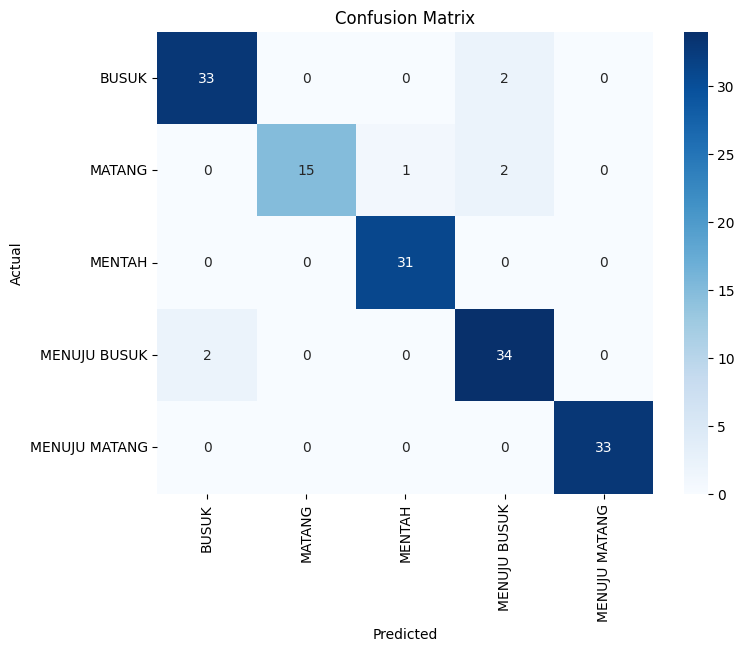

Accuracy: 95.42%
Precision: 95.58%
Recall: 95.42%
F1 Score: 95.39%


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn_classifier.classes_, yticklabels=knn_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')


In [ ]:
model_filename = 'knn_model.pkl'
joblib.dump(knn_classifier, model_filename)

print(f"K-NN model saved to {model_filename}")

K-NN model saved to knn_model.pkl


#### Hypertuning Parameter

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be

Best Hyperparameters: {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
best score: 0.962295081967213
Confusion Matrix:
[[34  0  0  1  0]
 [ 0 17  0  1  0]
 [ 0  0 31  0  0]
 [ 2  0  0 34  0]
 [ 0  0  0  0 33]]


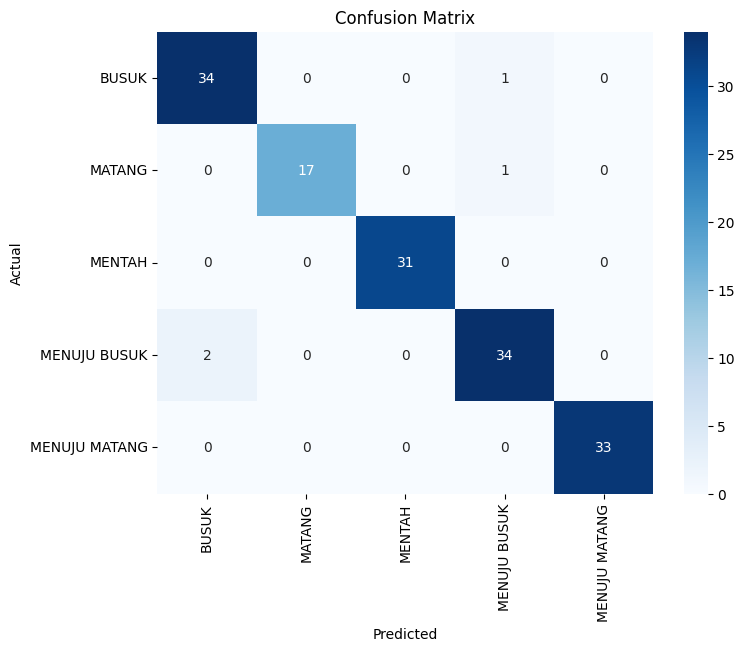

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the CSV file into a DataFrame
csv_filename = 'hsv_final_features.csv'
df = pd.read_csv(csv_filename)

# Separate features (X) and labels (y)
X = df[['Mean_Hue', 'Mean_Saturation', 'Mean_Value']]
y = df['Class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a k-NN classifier
knn_classifier = KNeighborsClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'n_neighbors' : [2,3,4,5,6,7,8,9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
    }

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, verbose = 1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')
print(f'best score: {grid_search.best_score_}')

# Train the classifier with the best hyperparameters
best_knn_classifier = grid_search.best_estimator_
best_knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_knn_classifier.predict(X_test)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_knn_classifier.classes_, yticklabels=best_knn_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
y_hat = best_knn_classifier.predict(X_train)
y_knn = best_knn_classifier.predict(X_test)

print('Training set accuracy: ', accuracy_score(y_train, y_hat))
print('Test set accuracy: ',accuracy_score(y_test, y_knn))


# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Training set accuracy:  1.0
Test set accuracy:  0.9738562091503268
Precision: 97.42%
Recall: 97.39%
F1 Score: 97.39%


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be

#### Evaluation

### Save Model

In [ ]:
# Get the best hyperparameters
best_hyperparameters = grid_search.best_params_
print(f"Best Hyperparameters: {best_hyperparameters}")

# Save the model with the best hyperparameters
best_knn_model = grid_search.best_estimator_
joblib.dump(best_knn_model, 'best_knn_model.pkl')

Best Hyperparameters: {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}


['best_knn_model.pkl']